# HW Instructions

In this exercise, you will be working with the ViT model for image classification using the CIFAR10 dataset. 

The task will involve going through the full machine learning lifecycle, including: preprocessing and exploratory data analysis, model implementation and training, tuning, and evaluation. 

It is assumed that you have some prior experience in the field from previous assignments. This assignment allows for flexibility in exploring and implementing solutions as you see fit.
Make sure you read the instructions carefully.

In [1]:
# feel free to add any imports you might need (as long as it is part of the course environment)
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models.vision_transformer import Encoder
import matplotlib.pyplot as plt
import collections
import copy

# Data Loading

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


     horse       deer        cat       deer


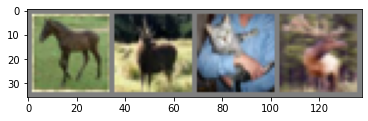

In [3]:
#############################################################################
# TO DO:                                                                    #
# plot a couple of images with their corresponding labels                   #
#############################################################################
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## A bit of exploratory data analysis (EDA)

In [4]:
#############################################################################
# TO DO:                                                                    #
# Figure out the size of the dataset:                                       #
# How many samples in train/test?                                            #
# How many labels? How many samples per label?                              #
# Try access train_dataset.__dict__.keys() to see which attributes          #
# are available on train_dataset.                                           #
#############################################################################
number_of_datapoints_in_train_dataset = len(train_dataset)
number_of_datapoints_in_test_dataset = len(test_dataset)

number_of_labels_in_train_dataset = max(train_dataset.targets) + 1
number_of_labels_in_test_dataset = max(test_dataset.targets) + 1

train_classes = [label for _, label in train_dataset]
samples_per_label_in_train_dataset = collections.Counter(train_classes)
samples_per_label_in_train_dataset = collections.OrderedDict(sorted(samples_per_label_in_train_dataset.items()))
samples_per_label_in_train_dataset = {classes[index]: number_of_datapoints for index, number_of_datapoints in samples_per_label_in_train_dataset.items()}
test_classes = [label for _, label in test_dataset]
samples_per_label_in_test_dataset = collections.Counter(test_classes)
samples_per_label_in_test_dataset = collections.OrderedDict(sorted(samples_per_label_in_test_dataset.items()))
samples_per_label_in_test_dataset = {classes[index]: number_of_datapoints for index, number_of_datapoints in samples_per_label_in_test_dataset.items()}


print('In train_dataset there are:')
print(f'{number_of_datapoints_in_train_dataset} samples,')
print(f'{number_of_labels_in_train_dataset} labels')
print(f'Samples per label:\n{samples_per_label_in_train_dataset}\n')

print('In test_dataset there are:')
print(f'{number_of_datapoints_in_test_dataset} samples,')
print(f'{number_of_labels_in_test_dataset} labels')
print(f'Samples per label:\n{samples_per_label_in_test_dataset}\n')

print(f'train_dataset.__dict__.keys() is: {train_dataset.__dict__.keys()}')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In train_dataset there are:
50000 samples,
10 labels
Samples per label:
{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}

In test_dataset there are:
10000 samples,
10 labels
Samples per label:
{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}

train_dataset.__dict__.keys() is: dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])


# Building ViT Model

In the next section, you will construct a Vision Transformer, a transformer-based image classifier. The goal of the ViT model is to bring advancements from the natural language processing field to computer vision. 

For this exercise, you will be required to implement the ViT model using a pre-built Encoder from the PyTorch library. Building the encoder can be challenging, so we have eliminated that step for you. If you are not familiar with the ViT model, it is highly recommended that you gain an understanding of its workings before beginning implementation. There is a ton of information available online, here is a pretty informative source:
https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline

In this assignment, you will be using a pre-built Encoder from the PyTorch library, which has already been loaded in the provided code. Therefore, you do not need to worry about the complexities of transformer computations when referring to the link provided.

In [5]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_layers, num_heads, hidden_dim, 
                 mlp_dim, dropout, attention_dropout):
        super().__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the required layers for your ViT model implementation.           #
        # Hint: For the curious among us, you can pick at pytorch's                 #
        # official implemetantion of vit (vit_b_16).                                #
        #############################################################################
        # initializing the encoder backbone
        # you should calculate the seq_length      
        seq_length = int(((image_size/patch_size) ** 2)) + 1

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.linear = nn.Linear((patch_size ** 2) * 3, hidden_dim)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, hidden_dim))
        self.encoder = Encoder(
        seq_length=seq_length,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
        attention_dropout=attention_dropout
        )       
        self.MLP = nn.Linear(hidden_dim, num_classes)

        self.data_tracking_for_visualization = {"train": {
            "acc": [],
            "loss": []
        }, "val": {
            "acc": [],
            "loss": []
        }}
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
  
    
        
    
        #############################################################################
        # TO DO:                                                                    #
        # Complete the rest of the class (foward method and other helper            #
        # functions if needed).                                                     #
        #############################################################################
    def forward(self, images):
        images = self.unfold(images).transpose(1, 2)
        images = self.linear(images)
        images = torch.cat((self.class_embedding.expand(images.shape[0], 1, images.shape[2]), images), 1)
        images = torch.add(images, self.positional_encoding.expand(images.shape))
        images = self.encoder(images)

        return self.MLP(images[:,0,:])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [6]:
# this is just a simple initialization, feel free to change it.
model = ViT(image_size=32, patch_size=8, num_classes=10, num_layers=2, num_heads=2, hidden_dim=128, 
                 mlp_dim=512, dropout=0.0, attention_dropout=0.0)

# Training

## IMPORTANT READ!

In the following section, you will be required to train your implementation of the ViT model as in previous assignments. However, it is important to note that training transformers can be challenging, especially when starting from scratch, as is the case in this exercise.

It is acceptable if your final model does not achieve a high accuracy score, but it is crucial to document your training experiments and demonstrate that the model is able to train correctly (i.e. the loss decreases over time). This includes noting what you tried, what parameters worked best, and providing the loss and accuracy graphs as instructed in the next sections.

A reference for training ViT on CIFAR10 can be found at https://github.com/omihub777/ViT-CIFAR. However, it's important to note that in the provided reference, the ViT model was trained using 200 epochs and over 2 hours of training.

Note 1: If the loss decreases and your model trains correctly, you are on the safe side. The focus should be on the experiments and the things you tried.

Note 2: The main goal is not to achieve a high accuracy score but to demonstrate that you understand the process.

Note 3: If your final model's performance is strictly better than a random model (accuracy of around 1/num_classes) and you have provided thorough documentation of your experiments and processes, you will receive full credit for the assignment. 

In [7]:
#############################################################################
# TO DO:                                                                    #
# Create a validation set from the training set
# Implement the training loop
# Save the loss and accuracy for both training/validation sets every couple of iterations for plotting afterwards.
#############################################################################
train_data, valid_data = random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=4)

def train_model(model, criterion, optimizer, num_epochs=5):
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-' * 10)

      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()
              current_loader = train_loader
              dataset_size = len(train_data)
          else:
              model.eval()
              current_loader = validation_loader
              dataset_size = len(valid_data)
          
          running_loss = 0.0
          running_corrects = 0

          for images, true_labels in current_loader:
            optimizer.zero_grad()
            MLP_scores = model(images)
            loss = criterion(MLP_scores, true_labels)
            if phase == 'train':
              loss.backward()
              optimizer.step()
            predicted_labels = torch.argmax(MLP_scores, dim=1)
            running_loss += loss.item()
            running_corrects += torch.sum(torch.eq(predicted_labels, true_labels), dim=0).item()
          
          epoch_loss = running_loss / dataset_size
          epoch_acc = running_corrects / dataset_size

          model.data_tracking_for_visualization[phase]['loss'].append(epoch_loss)
          model.data_tracking_for_visualization[phase]['acc'].append(epoch_acc)
            
          print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################





/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [9]:
train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.0557  |  Acc: 0.3515
val Loss: 0.0509  |  Acc: 0.4147
Epoch 2/10
----------
train Loss: 0.0488  |  Acc: 0.4342
val Loss: 0.0475  |  Acc: 0.4520
Epoch 3/10
----------
train Loss: 0.0455  |  Acc: 0.4743
val Loss: 0.0436  |  Acc: 0.4990
Epoch 4/10
----------
train Loss: 0.0426  |  Acc: 0.5055
val Loss: 0.0440  |  Acc: 0.4909
Epoch 5/10
----------
train Loss: 0.0404  |  Acc: 0.5311
val Loss: 0.0414  |  Acc: 0.5225
Epoch 6/10
----------
train Loss: 0.0386  |  Acc: 0.5554
val Loss: 0.0416  |  Acc: 0.5230
Epoch 7/10
----------
train Loss: 0.0368  |  Acc: 0.5745
val Loss: 0.0414  |  Acc: 0.5331
Epoch 8/10
----------
train Loss: 0.0352  |  Acc: 0.5959
val Loss: 0.0390  |  Acc: 0.5512
Epoch 9/10
----------
train Loss: 0.0336  |  Acc: 0.6128
val Loss: 0.0399  |  Acc: 0.5585
Epoch 10/10
----------
train Loss: 0.0320  |  Acc: 0.6293
val Loss: 0.0385  |  Acc: 0.5653


## Loss and Acurracy

In [10]:
# Plot 2 graphs:
# Graph 1: Loss vs itreation for training and validation sets
# Graph 2: Accuracy vs itreation for training and validation sets

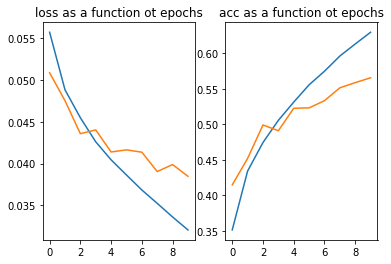

In [11]:
data_types = ['loss', 'acc']

for i in range(2):
  plt.subplot(1, 2, i+1)
  train_data_list = [x for x in model.data_tracking_for_visualization['train'][data_types[i]]]
  val_data_list = [x for x in model.data_tracking_for_visualization['val'][data_types[i]]]

  plt.plot(train_data_list, label='train')
  plt.plot(val_data_list, label='val')
  plt.title(f'{data_types[i]} as a function ot epochs')


plt.show()

# Evaluation 

In [12]:
# Calculate the accuracy of the final model on the test set.

Train accuracy: 0.5519
True Labels:
       cat       deer        dog      truck
Predicted Labels:
       cat       deer        cat automobile


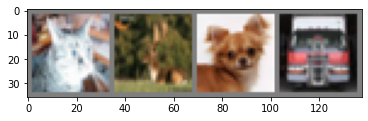

In [14]:
model.eval()
dataset_size = len(valid_data)
model.eval()

running_corrects = 0.0

for images, true_labels in testloader:
  optimizer.zero_grad()
  MLP_scores = model(images)
  predicted_labels = torch.argmax(MLP_scores, dim=1)
  running_corrects += torch.sum(torch.eq(predicted_labels, true_labels), dim=0).item()

accuracy = running_corrects / dataset_size

# show images
imshow(torchvision.utils.make_grid(images[:4]))

print(f'Train accuracy: {accuracy:.4f}')

# print labels
print('True Labels:')
print(' '.join('%10s' % classes[true_labels[j]]  for j in range(4)))
print('Predicted Labels:')
print(' '.join('%10s' % classes[predicted_labels[j]]  for j in range(4)))

            


# Questions

##**Question:** 

Explain the importance of the positional embedding in the ViT model.

**Your answer:** Adding positional embedding is like adding unique position to the linear projection of each patch so the vision transformer knows the arrangement of the sequence during training. Without that - the transformer can't know what is the correct order of the patches and even an unordered patches sequence might be tagged as if the patches were arranged correctly.

##**Question:** 

How would you evaluate the model if the number of samples per class would not be balanced?
How can you deal with class imbalance on multiclass classification?

**Your answer:** I can evaluate the model with confusion matrix, with Accuracy, Precision, Recall, F-score and with AUC-ROC, AUC-PR.
We can deal with class imbalance using random oversampling of samples or SMOTE (artificially generating samples based on the existing samples of the class with less samples).